# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

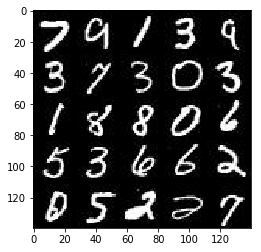

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

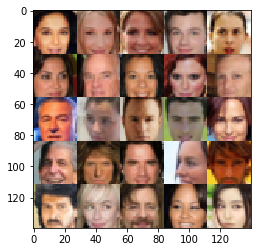

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate =tf.placeholder(tf.float32, name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        #first conv, no normalization, leaky relu with 0.1 alpha
        conv1 = tf.layers.conv2d(images, 128, 4, 2, padding='same', activation=None)
        conv1 = tf.maximum(conv1*alpha, conv1)
        #second conv, batch normalization, leaky relu with 0.1 alpha
        conv2 = tf.layers.conv2d(conv1, 256, 4, 2, padding='same', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(conv2*alpha, conv2)
        #third conv, batch normalization, leaky relu with 0.1 alpha
        conv3 = tf.layers.conv2d(conv2, 512, 4, 2, padding='same', activation=None)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(conv3*alpha, conv3)
        #reshape
        flat = tf.reshape(conv3, (-1, 4*4*512))
        #dense
        logits = tf.layers.dense(flat, 1)
        #sigmoid
        output = tf.nn.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [12]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        #dense
        dense = tf.layers.dense(z, 4*4*512)
        #reshape
        reshape = tf.reshape(dense, (-1, 4 , 4, 512))
        #conv1
        conv1 = tf.layers.conv2d_transpose(reshape, 256, 4, 1, padding='valid', activation=None)
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(conv1*alpha, conv1)
        #conv2
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, 2, padding='same', activation=None)
        conv2 = tf.layers.batch_normalization(conv2,training=is_train)
        conv2 = tf.maximum(conv2*alpha, conv2)
        #logits and output
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, 2, padding='same', activation=None)
        output = tf.tanh(logits)*0.5
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #generates fake images
    g_model = generator(input_z, out_channel_dim)
    #tests real images
    d_model_real, d_logits_real = discriminator(input_real)
    #tests fake images
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    #calculates discriminator loss on real images
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    #calculates discriminator loss on fake images
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    #calculates generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    #discriminator total loss
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #gets all trainable variables
    t_vars = tf.trainable_variables()
    #filters by name
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    #optmizes using AdamOptimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train, g_train = model_opt(d_loss, g_loss, lr, beta1)
    
    iterations = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                iterations += 1
                #noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #run
                sess.run(d_train, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                sess.run(g_train, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                sess.run(g_train, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                
                if iterations % 30 == 0 :
                    train_loss_d = d_loss.eval({input_real:batch_images,input_z:batch_z,lr:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images,input_z:batch_z,lr:learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}...".format(iterations),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                                    
                if iterations % 300 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 30... Discriminator Loss: 2.5578... Generator Loss: 0.1868
Epoch 1/2... Step 60... Discriminator Loss: 1.7824... Generator Loss: 0.4328
Epoch 1/2... Step 90... Discriminator Loss: 1.7343... Generator Loss: 0.2775
Epoch 1/2... Step 120... Discriminator Loss: 1.6162... Generator Loss: 0.7015
Epoch 1/2... Step 150... Discriminator Loss: 1.5931... Generator Loss: 0.9274
Epoch 1/2... Step 180... Discriminator Loss: 1.3808... Generator Loss: 0.9568
Epoch 1/2... Step 210... Discriminator Loss: 2.3777... Generator Loss: 0.1274
Epoch 1/2... Step 240... Discriminator Loss: 1.7131... Generator Loss: 0.3907
Epoch 1/2... Step 270... Discriminator Loss: 1.2816... Generator Loss: 1.1001
Epoch 1/2... Step 300... Discriminator Loss: 1.4750... Generator Loss: 0.4056


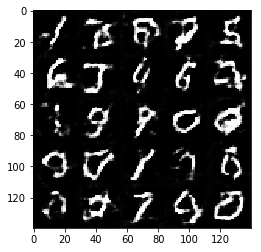

Epoch 1/2... Step 330... Discriminator Loss: 1.3368... Generator Loss: 0.5559
Epoch 1/2... Step 360... Discriminator Loss: 1.7059... Generator Loss: 0.3918
Epoch 1/2... Step 390... Discriminator Loss: 1.8443... Generator Loss: 0.2257
Epoch 1/2... Step 420... Discriminator Loss: 1.8149... Generator Loss: 0.2612
Epoch 1/2... Step 450... Discriminator Loss: 1.8947... Generator Loss: 0.2275
Epoch 1/2... Step 480... Discriminator Loss: 1.8082... Generator Loss: 0.2330
Epoch 1/2... Step 510... Discriminator Loss: 1.2974... Generator Loss: 1.0018
Epoch 1/2... Step 540... Discriminator Loss: 1.0510... Generator Loss: 0.7075
Epoch 1/2... Step 570... Discriminator Loss: 2.0048... Generator Loss: 0.1900
Epoch 1/2... Step 600... Discriminator Loss: 1.4995... Generator Loss: 0.6022


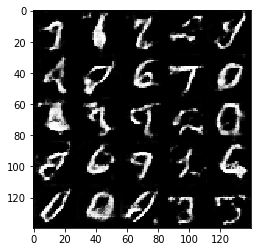

Epoch 1/2... Step 630... Discriminator Loss: 1.1869... Generator Loss: 0.6434
Epoch 1/2... Step 660... Discriminator Loss: 1.7275... Generator Loss: 0.2602
Epoch 1/2... Step 690... Discriminator Loss: 1.0163... Generator Loss: 1.0696
Epoch 1/2... Step 720... Discriminator Loss: 1.3680... Generator Loss: 0.4974
Epoch 1/2... Step 750... Discriminator Loss: 1.2360... Generator Loss: 0.5122
Epoch 1/2... Step 780... Discriminator Loss: 1.2285... Generator Loss: 0.5732
Epoch 1/2... Step 810... Discriminator Loss: 1.1819... Generator Loss: 1.0736
Epoch 1/2... Step 840... Discriminator Loss: 0.9244... Generator Loss: 0.8632
Epoch 1/2... Step 870... Discriminator Loss: 0.6386... Generator Loss: 1.5462
Epoch 1/2... Step 900... Discriminator Loss: 1.5045... Generator Loss: 0.3263


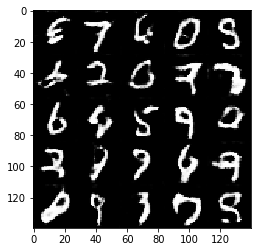

Epoch 1/2... Step 930... Discriminator Loss: 1.8851... Generator Loss: 0.2543
Epoch 1/2... Step 960... Discriminator Loss: 1.4668... Generator Loss: 0.3823
Epoch 1/2... Step 990... Discriminator Loss: 1.3321... Generator Loss: 0.4429
Epoch 1/2... Step 1020... Discriminator Loss: 1.7356... Generator Loss: 0.2675
Epoch 1/2... Step 1050... Discriminator Loss: 1.3634... Generator Loss: 1.9973
Epoch 1/2... Step 1080... Discriminator Loss: 1.4713... Generator Loss: 0.3786
Epoch 1/2... Step 1110... Discriminator Loss: 1.1387... Generator Loss: 0.6197
Epoch 1/2... Step 1140... Discriminator Loss: 1.2108... Generator Loss: 0.5437
Epoch 1/2... Step 1170... Discriminator Loss: 1.2988... Generator Loss: 0.4849
Epoch 1/2... Step 1200... Discriminator Loss: 1.7185... Generator Loss: 0.2582


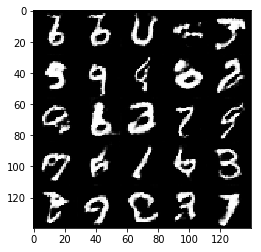

Epoch 1/2... Step 1230... Discriminator Loss: 1.6671... Generator Loss: 0.2956
Epoch 1/2... Step 1260... Discriminator Loss: 1.4492... Generator Loss: 0.3688
Epoch 1/2... Step 1290... Discriminator Loss: 2.4499... Generator Loss: 0.1590
Epoch 1/2... Step 1320... Discriminator Loss: 0.8749... Generator Loss: 0.9387
Epoch 1/2... Step 1350... Discriminator Loss: 1.8297... Generator Loss: 0.3095
Epoch 1/2... Step 1380... Discriminator Loss: 0.9320... Generator Loss: 0.8104
Epoch 1/2... Step 1410... Discriminator Loss: 1.4425... Generator Loss: 0.3808
Epoch 1/2... Step 1440... Discriminator Loss: 1.2720... Generator Loss: 0.4482
Epoch 1/2... Step 1470... Discriminator Loss: 1.0414... Generator Loss: 0.6857
Epoch 1/2... Step 1500... Discriminator Loss: 1.6710... Generator Loss: 0.3869


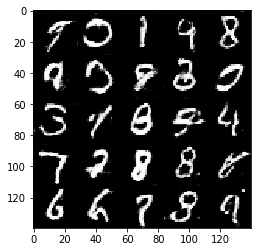

Epoch 1/2... Step 1530... Discriminator Loss: 2.1191... Generator Loss: 0.2390
Epoch 1/2... Step 1560... Discriminator Loss: 1.9956... Generator Loss: 0.2822
Epoch 1/2... Step 1590... Discriminator Loss: 1.0293... Generator Loss: 0.6845
Epoch 1/2... Step 1620... Discriminator Loss: 1.7990... Generator Loss: 0.2820
Epoch 1/2... Step 1650... Discriminator Loss: 0.9987... Generator Loss: 0.6703
Epoch 1/2... Step 1680... Discriminator Loss: 1.0907... Generator Loss: 0.7472
Epoch 1/2... Step 1710... Discriminator Loss: 1.7569... Generator Loss: 0.3359
Epoch 1/2... Step 1740... Discriminator Loss: 1.0017... Generator Loss: 0.7309
Epoch 1/2... Step 1770... Discriminator Loss: 0.7740... Generator Loss: 0.8228
Epoch 1/2... Step 1800... Discriminator Loss: 1.2552... Generator Loss: 0.5274


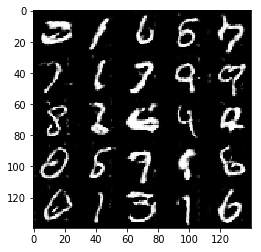

Epoch 1/2... Step 1830... Discriminator Loss: 2.4452... Generator Loss: 0.1610
Epoch 1/2... Step 1860... Discriminator Loss: 1.3840... Generator Loss: 0.5419
Epoch 2/2... Step 1890... Discriminator Loss: 0.8174... Generator Loss: 2.5261
Epoch 2/2... Step 1920... Discriminator Loss: 0.7347... Generator Loss: 1.1116
Epoch 2/2... Step 1950... Discriminator Loss: 0.6206... Generator Loss: 1.7832
Epoch 2/2... Step 1980... Discriminator Loss: 2.1306... Generator Loss: 0.2112
Epoch 2/2... Step 2010... Discriminator Loss: 1.3196... Generator Loss: 0.5919
Epoch 2/2... Step 2040... Discriminator Loss: 0.4204... Generator Loss: 1.4094
Epoch 2/2... Step 2070... Discriminator Loss: 1.3519... Generator Loss: 0.5558
Epoch 2/2... Step 2100... Discriminator Loss: 1.6952... Generator Loss: 0.3092


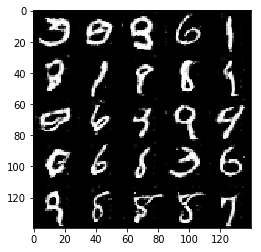

Epoch 2/2... Step 2130... Discriminator Loss: 1.4721... Generator Loss: 0.3618
Epoch 2/2... Step 2160... Discriminator Loss: 1.7646... Generator Loss: 0.2813
Epoch 2/2... Step 2190... Discriminator Loss: 1.3069... Generator Loss: 0.4504
Epoch 2/2... Step 2220... Discriminator Loss: 1.1245... Generator Loss: 0.6923
Epoch 2/2... Step 2250... Discriminator Loss: 1.3396... Generator Loss: 0.4171
Epoch 2/2... Step 2280... Discriminator Loss: 1.1197... Generator Loss: 0.6388
Epoch 2/2... Step 2310... Discriminator Loss: 1.1844... Generator Loss: 0.5550
Epoch 2/2... Step 2340... Discriminator Loss: 1.4310... Generator Loss: 0.5184
Epoch 2/2... Step 2370... Discriminator Loss: 1.4206... Generator Loss: 0.4874
Epoch 2/2... Step 2400... Discriminator Loss: 1.6439... Generator Loss: 0.4168


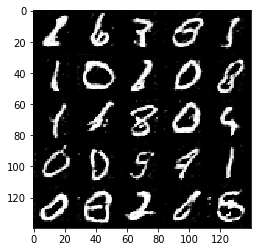

Epoch 2/2... Step 2430... Discriminator Loss: 1.7357... Generator Loss: 0.3102
Epoch 2/2... Step 2460... Discriminator Loss: 1.3206... Generator Loss: 0.5131
Epoch 2/2... Step 2490... Discriminator Loss: 1.1839... Generator Loss: 0.5040
Epoch 2/2... Step 2520... Discriminator Loss: 0.6628... Generator Loss: 1.1085
Epoch 2/2... Step 2550... Discriminator Loss: 0.9636... Generator Loss: 0.6455
Epoch 2/2... Step 2580... Discriminator Loss: 1.4414... Generator Loss: 0.4217
Epoch 2/2... Step 2610... Discriminator Loss: 1.7910... Generator Loss: 0.3473
Epoch 2/2... Step 2640... Discriminator Loss: 0.4836... Generator Loss: 4.2582
Epoch 2/2... Step 2670... Discriminator Loss: 1.2628... Generator Loss: 0.4919
Epoch 2/2... Step 2700... Discriminator Loss: 0.8302... Generator Loss: 0.9584


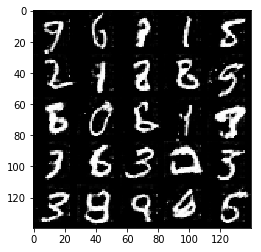

Epoch 2/2... Step 2730... Discriminator Loss: 0.3953... Generator Loss: 2.0644
Epoch 2/2... Step 2760... Discriminator Loss: 0.5406... Generator Loss: 1.3580
Epoch 2/2... Step 2790... Discriminator Loss: 1.5827... Generator Loss: 0.4301
Epoch 2/2... Step 2820... Discriminator Loss: 1.1487... Generator Loss: 0.6435
Epoch 2/2... Step 2850... Discriminator Loss: 0.7491... Generator Loss: 0.9863
Epoch 2/2... Step 2880... Discriminator Loss: 0.8847... Generator Loss: 1.5255
Epoch 2/2... Step 2910... Discriminator Loss: 0.6575... Generator Loss: 1.2656
Epoch 2/2... Step 2940... Discriminator Loss: 1.4040... Generator Loss: 0.4203
Epoch 2/2... Step 2970... Discriminator Loss: 0.8329... Generator Loss: 0.8196
Epoch 2/2... Step 3000... Discriminator Loss: 1.0737... Generator Loss: 0.5777


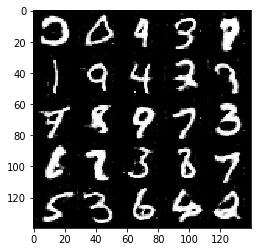

Epoch 2/2... Step 3030... Discriminator Loss: 1.7789... Generator Loss: 0.2875
Epoch 2/2... Step 3060... Discriminator Loss: 0.6362... Generator Loss: 1.1769
Epoch 2/2... Step 3090... Discriminator Loss: 1.1493... Generator Loss: 0.5790
Epoch 2/2... Step 3120... Discriminator Loss: 2.2887... Generator Loss: 0.1793
Epoch 2/2... Step 3150... Discriminator Loss: 1.8734... Generator Loss: 0.2588
Epoch 2/2... Step 3180... Discriminator Loss: 0.4512... Generator Loss: 1.4947
Epoch 2/2... Step 3210... Discriminator Loss: 2.3775... Generator Loss: 0.1803
Epoch 2/2... Step 3240... Discriminator Loss: 1.7082... Generator Loss: 0.4011
Epoch 2/2... Step 3270... Discriminator Loss: 1.5009... Generator Loss: 0.4069
Epoch 2/2... Step 3300... Discriminator Loss: 2.0458... Generator Loss: 0.2100


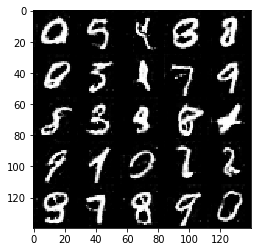

Epoch 2/2... Step 3330... Discriminator Loss: 1.7803... Generator Loss: 0.3721
Epoch 2/2... Step 3360... Discriminator Loss: 1.5737... Generator Loss: 4.7082
Epoch 2/2... Step 3390... Discriminator Loss: 1.7895... Generator Loss: 0.2988
Epoch 2/2... Step 3420... Discriminator Loss: 1.6403... Generator Loss: 0.3437
Epoch 2/2... Step 3450... Discriminator Loss: 2.9473... Generator Loss: 0.1181
Epoch 2/2... Step 3480... Discriminator Loss: 1.1237... Generator Loss: 4.3007
Epoch 2/2... Step 3510... Discriminator Loss: 1.1773... Generator Loss: 0.6405
Epoch 2/2... Step 3540... Discriminator Loss: 0.8879... Generator Loss: 1.1855
Epoch 2/2... Step 3570... Discriminator Loss: 1.4026... Generator Loss: 0.4739
Epoch 2/2... Step 3600... Discriminator Loss: 0.7755... Generator Loss: 2.6809


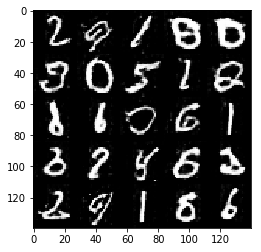

Epoch 2/2... Step 3630... Discriminator Loss: 1.4374... Generator Loss: 0.5733
Epoch 2/2... Step 3660... Discriminator Loss: 1.2975... Generator Loss: 0.4742
Epoch 2/2... Step 3690... Discriminator Loss: 2.5054... Generator Loss: 0.1455
Epoch 2/2... Step 3720... Discriminator Loss: 0.9770... Generator Loss: 1.1231
Epoch 2/2... Step 3750... Discriminator Loss: 1.1710... Generator Loss: 0.5245


In [29]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 30... Discriminator Loss: 3.1192... Generator Loss: 0.1034
Epoch 1/1... Step 60... Discriminator Loss: 2.7390... Generator Loss: 0.0936
Epoch 1/1... Step 90... Discriminator Loss: 2.6210... Generator Loss: 0.0922
Epoch 1/1... Step 120... Discriminator Loss: 1.8937... Generator Loss: 0.2016
Epoch 1/1... Step 150... Discriminator Loss: 2.0711... Generator Loss: 0.2149
Epoch 1/1... Step 180... Discriminator Loss: 1.7052... Generator Loss: 0.3885
Epoch 1/1... Step 210... Discriminator Loss: 1.9404... Generator Loss: 0.2700
Epoch 1/1... Step 240... Discriminator Loss: 1.5801... Generator Loss: 0.4865
Epoch 1/1... Step 270... Discriminator Loss: 1.6899... Generator Loss: 0.3529
Epoch 1/1... Step 300... Discriminator Loss: 1.9053... Generator Loss: 0.2115


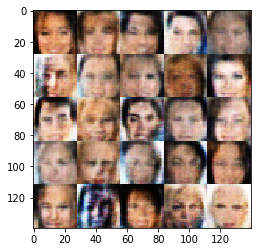

Epoch 1/1... Step 330... Discriminator Loss: 1.7976... Generator Loss: 0.3456
Epoch 1/1... Step 360... Discriminator Loss: 1.7191... Generator Loss: 0.3343
Epoch 1/1... Step 390... Discriminator Loss: 1.5918... Generator Loss: 0.5218
Epoch 1/1... Step 420... Discriminator Loss: 1.7926... Generator Loss: 0.5059
Epoch 1/1... Step 450... Discriminator Loss: 1.6476... Generator Loss: 0.3280
Epoch 1/1... Step 480... Discriminator Loss: 1.5338... Generator Loss: 0.5653
Epoch 1/1... Step 510... Discriminator Loss: 1.6695... Generator Loss: 0.4679
Epoch 1/1... Step 540... Discriminator Loss: 1.3486... Generator Loss: 0.7332
Epoch 1/1... Step 570... Discriminator Loss: 1.7056... Generator Loss: 0.4517
Epoch 1/1... Step 600... Discriminator Loss: 1.4490... Generator Loss: 0.5258


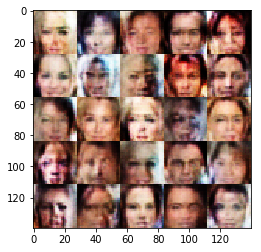

Epoch 1/1... Step 630... Discriminator Loss: 1.6681... Generator Loss: 0.3499
Epoch 1/1... Step 660... Discriminator Loss: 1.2579... Generator Loss: 0.7132
Epoch 1/1... Step 690... Discriminator Loss: 1.6783... Generator Loss: 0.3712
Epoch 1/1... Step 720... Discriminator Loss: 1.4721... Generator Loss: 0.4199
Epoch 1/1... Step 750... Discriminator Loss: 1.3076... Generator Loss: 1.1484
Epoch 1/1... Step 780... Discriminator Loss: 1.6207... Generator Loss: 0.3436
Epoch 1/1... Step 810... Discriminator Loss: 1.3470... Generator Loss: 0.7851
Epoch 1/1... Step 840... Discriminator Loss: 1.1760... Generator Loss: 0.8846
Epoch 1/1... Step 870... Discriminator Loss: 1.2336... Generator Loss: 0.6117
Epoch 1/1... Step 900... Discriminator Loss: 1.4847... Generator Loss: 0.5583


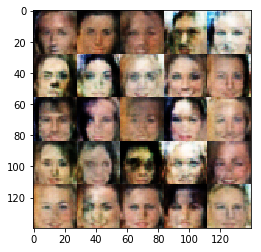

Epoch 1/1... Step 930... Discriminator Loss: 1.6565... Generator Loss: 0.3421
Epoch 1/1... Step 960... Discriminator Loss: 1.4407... Generator Loss: 0.5267
Epoch 1/1... Step 990... Discriminator Loss: 1.5460... Generator Loss: 0.4253
Epoch 1/1... Step 1020... Discriminator Loss: 1.3196... Generator Loss: 0.6682
Epoch 1/1... Step 1050... Discriminator Loss: 1.4208... Generator Loss: 0.5020
Epoch 1/1... Step 1080... Discriminator Loss: 1.5548... Generator Loss: 0.4009
Epoch 1/1... Step 1110... Discriminator Loss: 1.6056... Generator Loss: 0.3214
Epoch 1/1... Step 1140... Discriminator Loss: 1.4586... Generator Loss: 0.5207
Epoch 1/1... Step 1170... Discriminator Loss: 1.4369... Generator Loss: 0.7057
Epoch 1/1... Step 1200... Discriminator Loss: 1.4662... Generator Loss: 0.5748


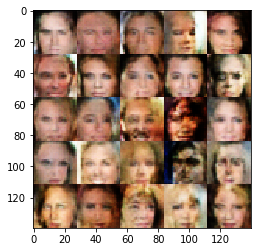

Epoch 1/1... Step 1230... Discriminator Loss: 1.5274... Generator Loss: 0.5462
Epoch 1/1... Step 1260... Discriminator Loss: 1.3970... Generator Loss: 0.5387
Epoch 1/1... Step 1290... Discriminator Loss: 1.8167... Generator Loss: 0.2924
Epoch 1/1... Step 1320... Discriminator Loss: 1.4836... Generator Loss: 0.3908
Epoch 1/1... Step 1350... Discriminator Loss: 1.5427... Generator Loss: 0.5396
Epoch 1/1... Step 1380... Discriminator Loss: 1.4051... Generator Loss: 0.4310
Epoch 1/1... Step 1410... Discriminator Loss: 1.4790... Generator Loss: 0.4510
Epoch 1/1... Step 1440... Discriminator Loss: 1.3985... Generator Loss: 0.4084
Epoch 1/1... Step 1470... Discriminator Loss: 1.3856... Generator Loss: 0.5399
Epoch 1/1... Step 1500... Discriminator Loss: 1.6134... Generator Loss: 0.3456


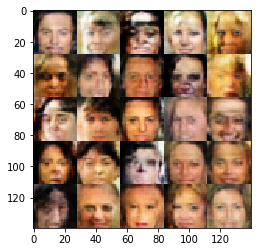

Epoch 1/1... Step 1530... Discriminator Loss: 1.3024... Generator Loss: 0.5918
Epoch 1/1... Step 1560... Discriminator Loss: 1.4339... Generator Loss: 0.5081
Epoch 1/1... Step 1590... Discriminator Loss: 1.6454... Generator Loss: 0.5374
Epoch 1/1... Step 1620... Discriminator Loss: 1.9040... Generator Loss: 0.3513
Epoch 1/1... Step 1650... Discriminator Loss: 1.6568... Generator Loss: 0.3029
Epoch 1/1... Step 1680... Discriminator Loss: 1.9137... Generator Loss: 0.2081
Epoch 1/1... Step 1710... Discriminator Loss: 1.8424... Generator Loss: 0.2285
Epoch 1/1... Step 1740... Discriminator Loss: 1.5999... Generator Loss: 0.3866
Epoch 1/1... Step 1770... Discriminator Loss: 1.5099... Generator Loss: 0.4191
Epoch 1/1... Step 1800... Discriminator Loss: 1.9374... Generator Loss: 0.1965


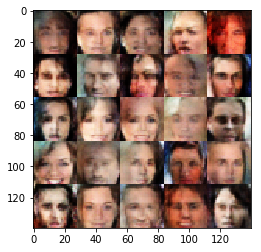

Epoch 1/1... Step 1830... Discriminator Loss: 1.7209... Generator Loss: 0.4077
Epoch 1/1... Step 1860... Discriminator Loss: 1.8684... Generator Loss: 0.2468
Epoch 1/1... Step 1890... Discriminator Loss: 1.5533... Generator Loss: 0.4309
Epoch 1/1... Step 1920... Discriminator Loss: 1.2834... Generator Loss: 1.0693
Epoch 1/1... Step 1950... Discriminator Loss: 1.4014... Generator Loss: 0.5454
Epoch 1/1... Step 1980... Discriminator Loss: 1.8093... Generator Loss: 0.2353
Epoch 1/1... Step 2010... Discriminator Loss: 1.3380... Generator Loss: 0.9870
Epoch 1/1... Step 2040... Discriminator Loss: 1.8890... Generator Loss: 0.2967
Epoch 1/1... Step 2070... Discriminator Loss: 1.8459... Generator Loss: 0.2310
Epoch 1/1... Step 2100... Discriminator Loss: 1.3363... Generator Loss: 0.5486


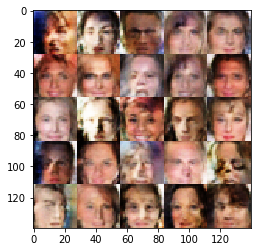

Epoch 1/1... Step 2130... Discriminator Loss: 1.5124... Generator Loss: 0.5917
Epoch 1/1... Step 2160... Discriminator Loss: 1.9729... Generator Loss: 0.2084
Epoch 1/1... Step 2190... Discriminator Loss: 1.4654... Generator Loss: 0.4335
Epoch 1/1... Step 2220... Discriminator Loss: 1.4011... Generator Loss: 0.6463
Epoch 1/1... Step 2250... Discriminator Loss: 1.8665... Generator Loss: 0.4381
Epoch 1/1... Step 2280... Discriminator Loss: 1.4838... Generator Loss: 0.4184
Epoch 1/1... Step 2310... Discriminator Loss: 1.4127... Generator Loss: 0.5493
Epoch 1/1... Step 2340... Discriminator Loss: 1.4977... Generator Loss: 0.4896
Epoch 1/1... Step 2370... Discriminator Loss: 1.4814... Generator Loss: 0.3982
Epoch 1/1... Step 2400... Discriminator Loss: 1.4802... Generator Loss: 0.6133


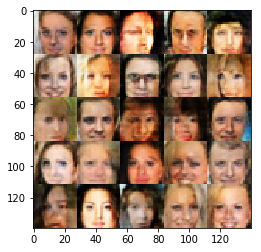

Epoch 1/1... Step 2430... Discriminator Loss: 1.8048... Generator Loss: 0.2839
Epoch 1/1... Step 2460... Discriminator Loss: 2.0453... Generator Loss: 0.1661
Epoch 1/1... Step 2490... Discriminator Loss: 1.5394... Generator Loss: 0.3909
Epoch 1/1... Step 2520... Discriminator Loss: 1.8451... Generator Loss: 0.2290
Epoch 1/1... Step 2550... Discriminator Loss: 2.1218... Generator Loss: 0.1677
Epoch 1/1... Step 2580... Discriminator Loss: 1.6256... Generator Loss: 0.6917
Epoch 1/1... Step 2610... Discriminator Loss: 1.5591... Generator Loss: 0.3452
Epoch 1/1... Step 2640... Discriminator Loss: 1.5228... Generator Loss: 0.6481
Epoch 1/1... Step 2670... Discriminator Loss: 1.6833... Generator Loss: 0.4513
Epoch 1/1... Step 2700... Discriminator Loss: 1.7234... Generator Loss: 0.3384


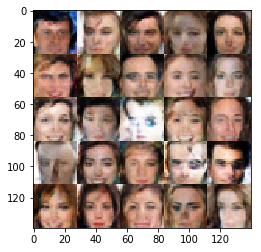

Epoch 1/1... Step 2730... Discriminator Loss: 1.4346... Generator Loss: 0.5141
Epoch 1/1... Step 2760... Discriminator Loss: 1.4506... Generator Loss: 0.6463
Epoch 1/1... Step 2790... Discriminator Loss: 1.3283... Generator Loss: 0.5176
Epoch 1/1... Step 2820... Discriminator Loss: 1.4566... Generator Loss: 0.5411
Epoch 1/1... Step 2850... Discriminator Loss: 1.7377... Generator Loss: 0.3953
Epoch 1/1... Step 2880... Discriminator Loss: 1.5939... Generator Loss: 0.3691
Epoch 1/1... Step 2910... Discriminator Loss: 1.4800... Generator Loss: 0.4127
Epoch 1/1... Step 2940... Discriminator Loss: 1.5408... Generator Loss: 0.6864
Epoch 1/1... Step 2970... Discriminator Loss: 1.7373... Generator Loss: 0.2467
Epoch 1/1... Step 3000... Discriminator Loss: 2.2061... Generator Loss: 0.1433


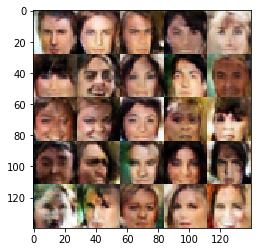

Epoch 1/1... Step 3030... Discriminator Loss: 1.9287... Generator Loss: 0.2422
Epoch 1/1... Step 3060... Discriminator Loss: 1.5199... Generator Loss: 0.4440
Epoch 1/1... Step 3090... Discriminator Loss: 1.5778... Generator Loss: 0.5492
Epoch 1/1... Step 3120... Discriminator Loss: 1.7945... Generator Loss: 0.2196
Epoch 1/1... Step 3150... Discriminator Loss: 1.4062... Generator Loss: 0.5626
Epoch 1/1... Step 3180... Discriminator Loss: 1.6781... Generator Loss: 0.3238
Epoch 1/1... Step 3210... Discriminator Loss: 1.5761... Generator Loss: 0.6284
Epoch 1/1... Step 3240... Discriminator Loss: 1.9090... Generator Loss: 0.2163
Epoch 1/1... Step 3270... Discriminator Loss: 1.6785... Generator Loss: 0.3746
Epoch 1/1... Step 3300... Discriminator Loss: 1.9597... Generator Loss: 0.1810


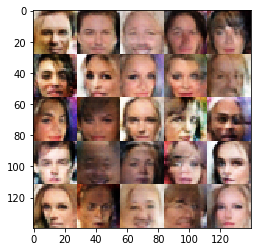

Epoch 1/1... Step 3330... Discriminator Loss: 2.0544... Generator Loss: 0.1783
Epoch 1/1... Step 3360... Discriminator Loss: 1.4777... Generator Loss: 0.7188
Epoch 1/1... Step 3390... Discriminator Loss: 1.7200... Generator Loss: 0.2844
Epoch 1/1... Step 3420... Discriminator Loss: 1.8903... Generator Loss: 0.2242
Epoch 1/1... Step 3450... Discriminator Loss: 1.8580... Generator Loss: 0.2675
Epoch 1/1... Step 3480... Discriminator Loss: 1.6966... Generator Loss: 0.2478
Epoch 1/1... Step 3510... Discriminator Loss: 1.7982... Generator Loss: 0.2296
Epoch 1/1... Step 3540... Discriminator Loss: 1.3685... Generator Loss: 0.5449
Epoch 1/1... Step 3570... Discriminator Loss: 1.6447... Generator Loss: 0.5110
Epoch 1/1... Step 3600... Discriminator Loss: 1.7203... Generator Loss: 0.3588


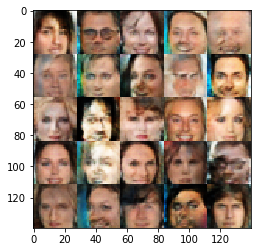

Epoch 1/1... Step 3630... Discriminator Loss: 1.6668... Generator Loss: 0.3363
Epoch 1/1... Step 3660... Discriminator Loss: 1.6383... Generator Loss: 0.3015
Epoch 1/1... Step 3690... Discriminator Loss: 1.7289... Generator Loss: 0.2987
Epoch 1/1... Step 3720... Discriminator Loss: 1.9814... Generator Loss: 0.2242
Epoch 1/1... Step 3750... Discriminator Loss: 2.2586... Generator Loss: 0.1364
Epoch 1/1... Step 3780... Discriminator Loss: 1.7701... Generator Loss: 0.2452
Epoch 1/1... Step 3810... Discriminator Loss: 1.5795... Generator Loss: 0.3331
Epoch 1/1... Step 3840... Discriminator Loss: 1.7362... Generator Loss: 0.3404
Epoch 1/1... Step 3870... Discriminator Loss: 1.7759... Generator Loss: 0.2317
Epoch 1/1... Step 3900... Discriminator Loss: 1.4952... Generator Loss: 0.3292


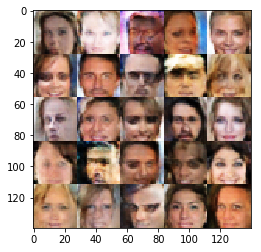

Epoch 1/1... Step 3930... Discriminator Loss: 2.7299... Generator Loss: 1.8723
Epoch 1/1... Step 3960... Discriminator Loss: 1.8280... Generator Loss: 0.2482
Epoch 1/1... Step 3990... Discriminator Loss: 1.9448... Generator Loss: 0.1957
Epoch 1/1... Step 4020... Discriminator Loss: 2.2347... Generator Loss: 0.1372
Epoch 1/1... Step 4050... Discriminator Loss: 1.5480... Generator Loss: 0.8696
Epoch 1/1... Step 4080... Discriminator Loss: 1.7480... Generator Loss: 0.4431
Epoch 1/1... Step 4110... Discriminator Loss: 2.3855... Generator Loss: 0.1162
Epoch 1/1... Step 4140... Discriminator Loss: 1.7477... Generator Loss: 0.3367
Epoch 1/1... Step 4170... Discriminator Loss: 1.9530... Generator Loss: 0.1970
Epoch 1/1... Step 4200... Discriminator Loss: 1.4207... Generator Loss: 0.4754


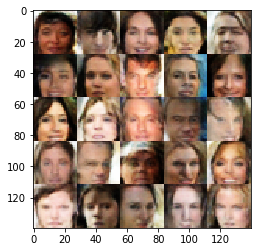

Epoch 1/1... Step 4230... Discriminator Loss: 1.7016... Generator Loss: 0.3094
Epoch 1/1... Step 4260... Discriminator Loss: 1.3097... Generator Loss: 0.5060
Epoch 1/1... Step 4290... Discriminator Loss: 1.5376... Generator Loss: 0.6769
Epoch 1/1... Step 4320... Discriminator Loss: 1.9606... Generator Loss: 0.2050
Epoch 1/1... Step 4350... Discriminator Loss: 1.5917... Generator Loss: 0.3930
Epoch 1/1... Step 4380... Discriminator Loss: 1.5723... Generator Loss: 0.4242
Epoch 1/1... Step 4410... Discriminator Loss: 1.9195... Generator Loss: 0.2126
Epoch 1/1... Step 4440... Discriminator Loss: 2.4879... Generator Loss: 0.1101
Epoch 1/1... Step 4470... Discriminator Loss: 2.1260... Generator Loss: 0.1743
Epoch 1/1... Step 4500... Discriminator Loss: 1.9770... Generator Loss: 0.1853


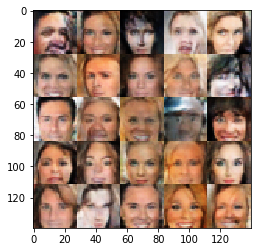

Epoch 1/1... Step 4530... Discriminator Loss: 1.9124... Generator Loss: 0.2048
Epoch 1/1... Step 4560... Discriminator Loss: 1.2538... Generator Loss: 0.5629
Epoch 1/1... Step 4590... Discriminator Loss: 1.5525... Generator Loss: 0.3620
Epoch 1/1... Step 4620... Discriminator Loss: 2.0122... Generator Loss: 0.2027
Epoch 1/1... Step 4650... Discriminator Loss: 1.6880... Generator Loss: 0.3068
Epoch 1/1... Step 4680... Discriminator Loss: 2.2188... Generator Loss: 0.1355
Epoch 1/1... Step 4710... Discriminator Loss: 1.8008... Generator Loss: 0.2712
Epoch 1/1... Step 4740... Discriminator Loss: 1.8629... Generator Loss: 0.2505
Epoch 1/1... Step 4770... Discriminator Loss: 2.1215... Generator Loss: 0.1687
Epoch 1/1... Step 4800... Discriminator Loss: 2.2967... Generator Loss: 0.1460


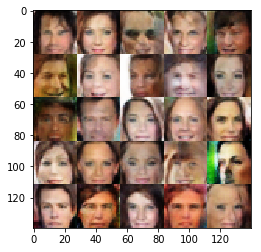

Epoch 1/1... Step 4830... Discriminator Loss: 1.6910... Generator Loss: 0.2796
Epoch 1/1... Step 4860... Discriminator Loss: 1.6627... Generator Loss: 0.3204
Epoch 1/1... Step 4890... Discriminator Loss: 1.7028... Generator Loss: 0.4439
Epoch 1/1... Step 4920... Discriminator Loss: 1.3182... Generator Loss: 0.5291
Epoch 1/1... Step 4950... Discriminator Loss: 2.0075... Generator Loss: 0.1860
Epoch 1/1... Step 4980... Discriminator Loss: 2.3269... Generator Loss: 0.1241
Epoch 1/1... Step 5010... Discriminator Loss: 2.1264... Generator Loss: 0.1515
Epoch 1/1... Step 5040... Discriminator Loss: 1.7408... Generator Loss: 0.2608
Epoch 1/1... Step 5070... Discriminator Loss: 1.6922... Generator Loss: 0.3532
Epoch 1/1... Step 5100... Discriminator Loss: 1.8093... Generator Loss: 0.4137


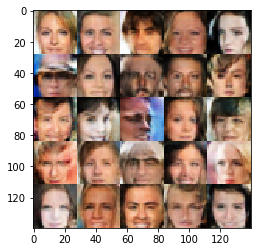

Epoch 1/1... Step 5130... Discriminator Loss: 1.6295... Generator Loss: 0.6468
Epoch 1/1... Step 5160... Discriminator Loss: 1.5106... Generator Loss: 0.6361
Epoch 1/1... Step 5190... Discriminator Loss: 1.8909... Generator Loss: 0.1984
Epoch 1/1... Step 5220... Discriminator Loss: 1.9413... Generator Loss: 0.2192
Epoch 1/1... Step 5250... Discriminator Loss: 1.4548... Generator Loss: 0.6703
Epoch 1/1... Step 5280... Discriminator Loss: 2.1301... Generator Loss: 0.1728
Epoch 1/1... Step 5310... Discriminator Loss: 1.8069... Generator Loss: 0.3108
Epoch 1/1... Step 5340... Discriminator Loss: 1.7317... Generator Loss: 0.7506
Epoch 1/1... Step 5370... Discriminator Loss: 1.6738... Generator Loss: 0.2991
Epoch 1/1... Step 5400... Discriminator Loss: 1.8100... Generator Loss: 0.2245


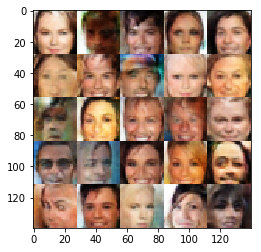

Epoch 1/1... Step 5430... Discriminator Loss: 2.1244... Generator Loss: 0.1830
Epoch 1/1... Step 5460... Discriminator Loss: 2.2226... Generator Loss: 0.1423
Epoch 1/1... Step 5490... Discriminator Loss: 1.6802... Generator Loss: 0.2898
Epoch 1/1... Step 5520... Discriminator Loss: 2.2009... Generator Loss: 0.1610
Epoch 1/1... Step 5550... Discriminator Loss: 1.8530... Generator Loss: 0.2306
Epoch 1/1... Step 5580... Discriminator Loss: 2.2319... Generator Loss: 0.1347
Epoch 1/1... Step 5610... Discriminator Loss: 1.3426... Generator Loss: 0.5303
Epoch 1/1... Step 5640... Discriminator Loss: 2.4548... Generator Loss: 0.1147
Epoch 1/1... Step 5670... Discriminator Loss: 2.8425... Generator Loss: 0.3635
Epoch 1/1... Step 5700... Discriminator Loss: 1.6859... Generator Loss: 0.2961


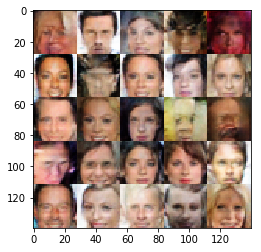

Epoch 1/1... Step 5730... Discriminator Loss: 1.5601... Generator Loss: 0.3211
Epoch 1/1... Step 5760... Discriminator Loss: 2.2021... Generator Loss: 0.1521
Epoch 1/1... Step 5790... Discriminator Loss: 1.9672... Generator Loss: 0.1980
Epoch 1/1... Step 5820... Discriminator Loss: 1.7340... Generator Loss: 0.3576
Epoch 1/1... Step 5850... Discriminator Loss: 1.3964... Generator Loss: 1.0014
Epoch 1/1... Step 5880... Discriminator Loss: 1.7929... Generator Loss: 0.3091
Epoch 1/1... Step 5910... Discriminator Loss: 2.1316... Generator Loss: 0.1772
Epoch 1/1... Step 5940... Discriminator Loss: 2.2684... Generator Loss: 0.1367
Epoch 1/1... Step 5970... Discriminator Loss: 1.2031... Generator Loss: 0.8909
Epoch 1/1... Step 6000... Discriminator Loss: 2.2738... Generator Loss: 0.1315


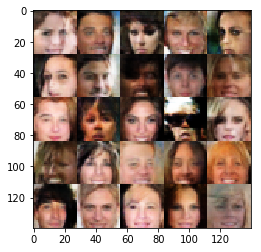

KeyboardInterrupt: 

In [30]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.